## 1. Import Library

In [71]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers

## 2. Data Understanding

In [2]:
directory = "./data"

data = {}

for file in os.listdir(directory):
    dataframe = os.path.splitext(file)[0]
    data[dataframe] = pd.read_csv(os.path.join(directory, file), delimiter=",") 

### 2.1 Gathering Data

In [3]:
df_movies = data['movies']
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
10324,146684,Cosmic Scrat-tastrophe (2015),Animation|Children|Comedy
10325,146878,Le Grand Restaurant (1966),Comedy
10326,148238,A Very Murray Christmas (2015),Comedy
10327,148626,The Big Short (2015),Drama


In [4]:
df_ratings = data['ratings']
df_ratings

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523
...,...,...,...,...
105334,668,142488,4.0,1451535844
105335,668,142507,3.5,1451535889
105336,668,143385,4.0,1446388585
105337,668,144976,2.5,1448656898


### 2.2 Check the dimensions of the data

In [5]:
df_movies.shape

(10329, 3)

In [6]:
df_ratings.shape

(105339, 4)

## 3. Univariate Exploratory Data Analysis

#### Movies Dataset

Attribute  | Keterangan
------------- | -------------
movieId | merepresentasikan Id unik untuk setiap film
title | merepresentasikan judul untuk setiap film
genres | merepresentasikan genre untuk setiap film

#### Ratings Dataset

Attribute  | Keterangan
------------- | -------------
userId | merepresentasikan Id unik untuk setiap penonton
movieId | merepresentasikan Id unik untuk setiap film     
rating | merepresentasikan penilaian yang diberikan oleh penonton
timestamp | merepresentasikan waktu ketika penilaian diberikan

### 3.1 Mengecek tipe data pada setiap atribut

In [7]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


### 3.2 Mengecek deskripsi data pada dataframe

In [9]:
df_movies.describe(include='object')

,title,genres
count,10329,10329
unique,10327,938
top,War of the Worlds (2005),Drama
freq,2,1385


In [10]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


### 3.3 Mengecek jumlah baris data dari setiap nilai unik

In [86]:
print('Jumlah Film: ', len(df_movies.movieId.value_counts()))
print('Jumlah Penonton: ', len(df_ratings.userId.value_counts()))

Jumlah Film:  10327
Jumlah Penonton:  668


In [12]:
df_movies['genres'].value_counts()

genres
Drama                                        1385
Comedy                                        826
Comedy|Drama                                  465
Drama|Romance                                 421
Comedy|Romance                                363
                                             ... 
Animation|Children|Comedy|Musical|Western       1
Action|Adventure|Children|Comedy|Mystery        1
Action|Comedy|Crime|Drama|Horror|Thriller       1
Adventure|Drama|Romance|Thriller|War            1
Action|Fantasy|Mystery                          1
Name: count, Length: 938, dtype: int64

In [13]:
df_ratings['rating'].value_counts().sort_index(ascending=False)

rating
5.0    14856
4.5     8187
4.0    28880
3.5    12237
3.0    21729
2.5     5484
2.0     7943
1.5     1567
1.0     3258
0.5     1198
Name: count, dtype: int64

In [14]:
movie_stat = df_ratings.groupby('movieId').agg({'rating':'sum', 'userId': 'count'}).reset_index()
movie_stat.columns = ['movieId', 'rating', 'num_users']

result_df = pd.merge(df_movies, movie_stat, on='movieId')
result_df = result_df.sort_values(by='rating', ascending=False)
top_rated_movies = result_df.head(10)

top_rated_movies[['title', 'rating', 'num_users']]


,title,rating,num_users
279,"Shawshank Redemption, The (1994)",1372.0,308
260,Pulp Fiction (1994),1352.0,325
316,Forrest Gump (1994),1287.0,311
525,"Silence of the Lambs, The (1991)",1216.5,290
230,Star Wars: Episode IV - A New Hope (1977),1143.5,273
2056,"Matrix, The (1999)",1113.0,261
426,Jurassic Park (1993),1076.0,294
471,Schindler's List (1993),1065.5,248
98,Braveheart (1995),1019.0,248
522,Terminator 2: Judgment Day (1991),1002.0,253


In [15]:
movie_stats = df_ratings.groupby('movieId').agg({'rating': 'mean', 'userId': 'count'}).reset_index()
movie_stats.columns = ['movieId', 'average_rating', 'num_users']

result_df = pd.merge(df_movies, movie_stats, on='movieId')
result_df = result_df.sort_values(by='num_users', ascending=False)
most_rated_movies = result_df.head(10)

most_rated_movies[['title', 'average_rating', 'num_users']]


,title,average_rating,num_users
260,Pulp Fiction (1994),4.160000,325
316,Forrest Gump (1994),4.138264,311
279,"Shawshank Redemption, The (1994)",4.454545,308
426,Jurassic Park (1993),3.659864,294
525,"Silence of the Lambs, The (1991)",4.194828,290
230,Star Wars: Episode IV - A New Hope (1977),4.188645,273
2056,"Matrix, The (1999)",4.264368,261
522,Terminator 2: Judgment Day (1991),3.960474,253
471,Schindler's List (1993),4.296371,248
98,Braveheart (1995),4.108871,248


In [77]:
genre_stats = pd.merge(df_movies, movie_stats, on='movieId')
genre_stats = genre_stats.assign(genres=result_df['genres'].str.split('|')).explode('genres')

genre_stats = genre_stats.groupby('genres').agg({'average_rating': 'mean', 'num_users': 'sum'}).reset_index()
top_genre_ratings = genre_stats.sort_values(by='average_rating', ascending=False)
top_genre_ratings[['genres', 'average_rating', 'num_users']]


,genres,average_rating,num_users
0,(no genres listed),3.500000,6
10,Film-Noir,3.403108,1463
18,War,3.308078,5658
19,Western,3.305188,2415
7,Documentary,3.289218,1731
13,Musical,3.276181,4510
8,Drama,3.274313,48122
15,Romance,3.238567,19268
14,Mystery,3.223496,7954
6,Crime,3.208210,17491


## 4. Visualisasi Data

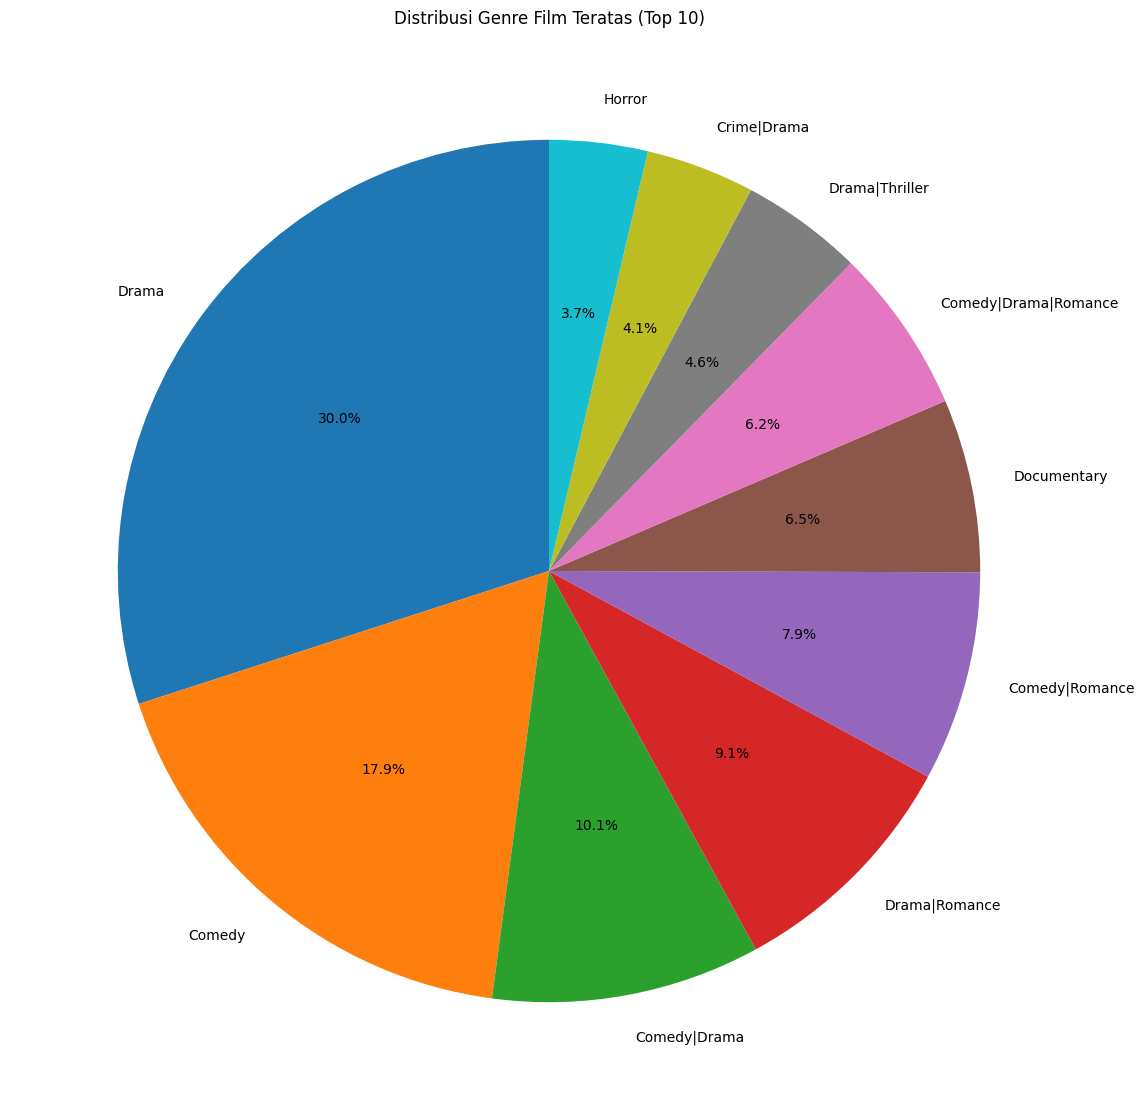

In [54]:
plt.figure(figsize=(14, 14))

value_counts = df_movies['genres'].value_counts().head(10)
value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)

plt.title('Distribusi Genre Film Teratas (Top 10)')
plt.ylabel('')

plt.show()

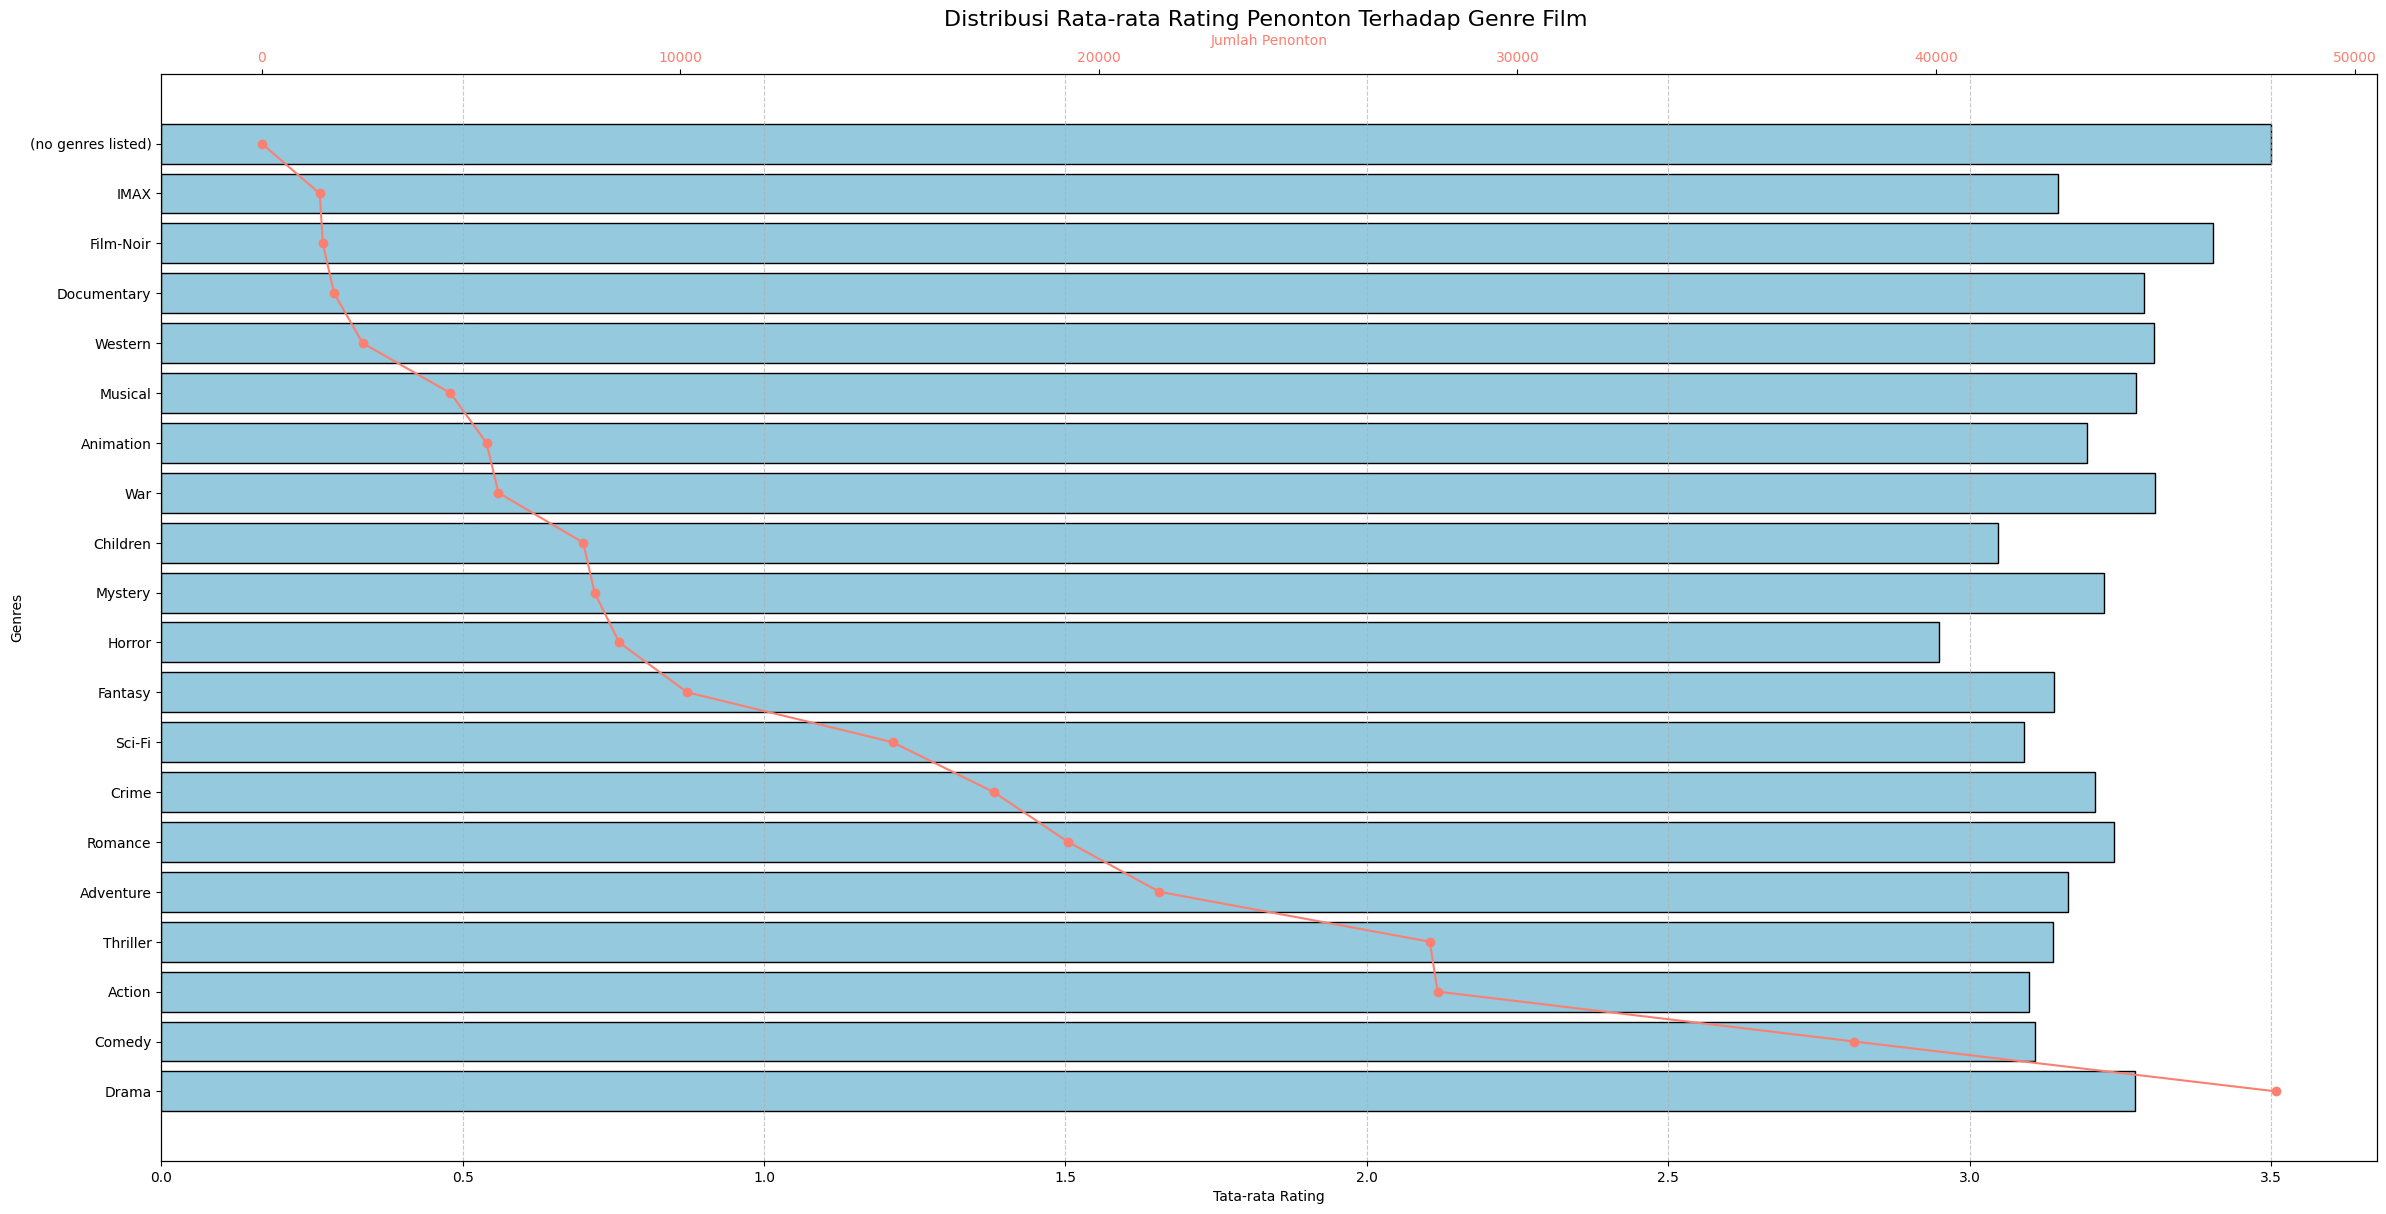

In [87]:
top_genre_ratings_sorted = top_genre_ratings.sort_values(by='num_users', ascending=True)

fig, ax1 = plt.subplots(figsize=(24, 12))

ax1.set_xlabel('Tata-rata Rating')
ax1.set_ylabel('Genres')
sns.barplot(x='average_rating', y='genres', data=top_genre_ratings_sorted, color='skyblue', ax=ax1, edgecolor='black')
ax1.tick_params(axis='x')

ax2 = ax1.twiny()
color = 'salmon'
ax2.set_xlabel('Jumlah Penonton', color=color)
ax2.plot(top_genre_ratings_sorted['num_users'], top_genre_ratings_sorted['genres'], color=color, marker='o')
ax2.tick_params(axis='x', labelcolor=color)

plt.yticks(fontsize=12)

ax1.grid(axis='x', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.title('Distribusi Rata-rata Rating Penonton Terhadap Genre Film ', fontsize=16)
plt.show()

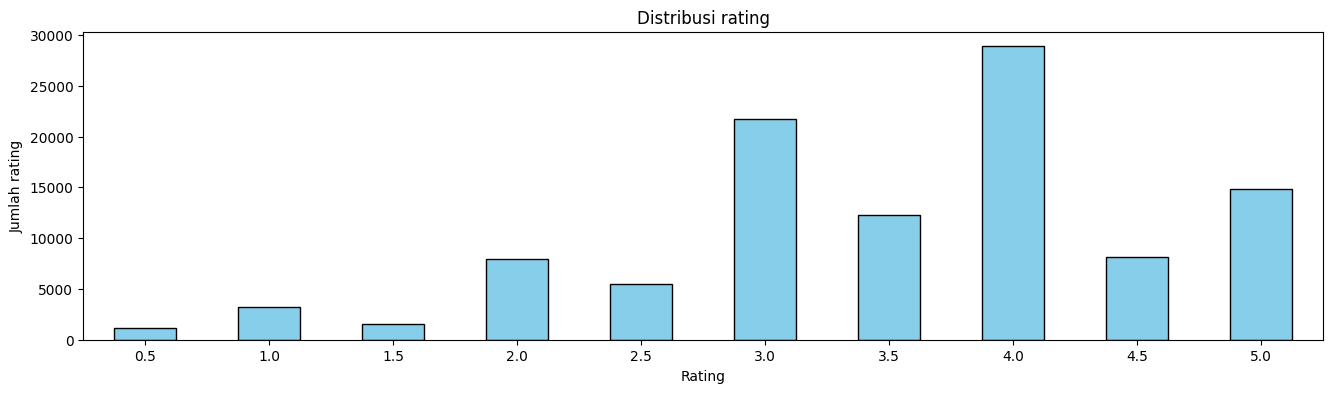

In [17]:
plt.figure(figsize=(16, 4))
rating = df_ratings['rating'].value_counts().sort_index().index
df_ratings['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribusi rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah rating')
plt.xticks(rotation=0)
plt.show()

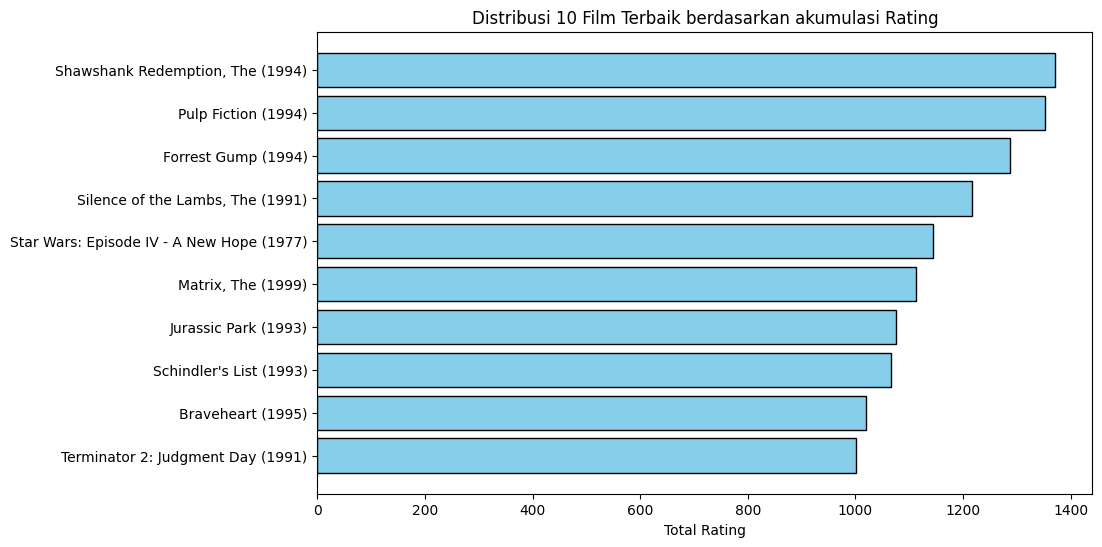

In [70]:
plt.figure(figsize=(10, 6))
plt.barh(top_rated_movies['title'], top_rated_movies['rating'], color='skyblue', edgecolor='black')
plt.xlabel('Jumlah Rating')
plt.title('Distribusi 10 Film Terbaik berdasarkan akumulasi Rating')
plt.gca().invert_yaxis()
plt.show()

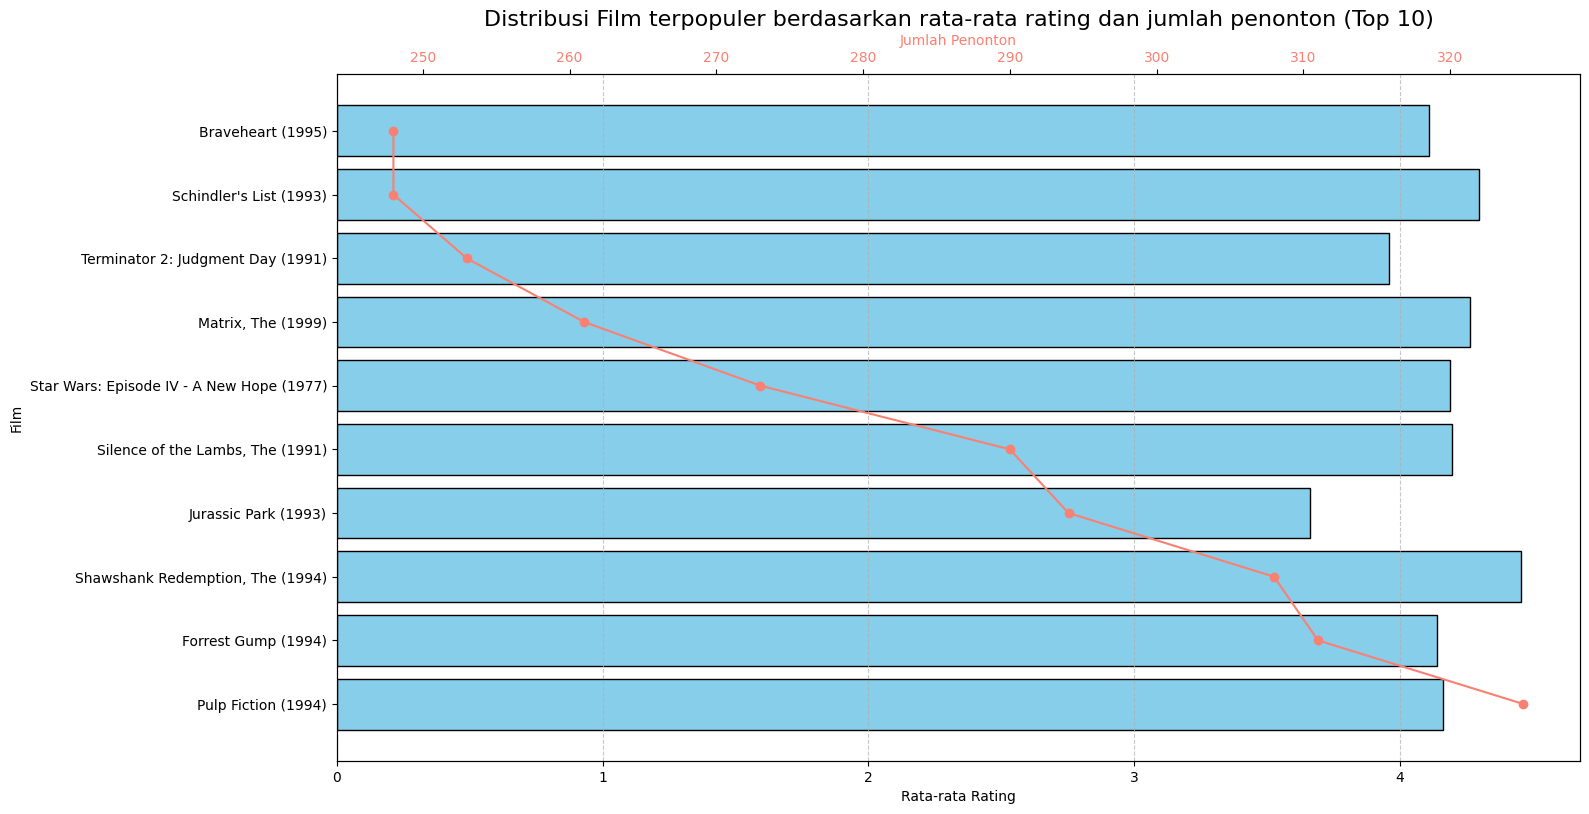

In [88]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'skyblue'
ax1.set_xlabel('Rata-rata Rating')
ax1.set_ylabel('Film')
ax1.barh(most_rated_movies['title'], most_rated_movies['average_rating'], color=color, edgecolor='black')
ax1.tick_params(axis='x')

ax2 = ax1.twiny()
color = 'salmon' 
ax2.set_xlabel('Jumlah Penonton', color=color)
ax2.plot(most_rated_movies['num_users'], most_rated_movies['title'], color=color, marker='o')
ax2.tick_params(axis='x', labelcolor=color)

plt.yticks(fontsize=12)

ax1.grid(axis='x', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.title('Distribusi Film terpopuler berdasarkan rata-rata rating dan jumlah penonton (Top 10)', fontsize=16)
plt.show()

## 5. Data Preprocessing

### 5.1 Data Preparation

#### Movies Dataset

Mengatasi duplikasi data

In [20]:
df_movies[df_movies['title'].duplicated()]

,movieId,title,genres
6270,26982,Men with Guns (1997),Drama
7963,64997,War of the Worlds (2005),Action|Sci-Fi


In [21]:
df_movies[df_movies['title'] == "Men with Guns (1997)"]

,movieId,title,genres
1403,1788,Men with Guns (1997),Action|Drama
6270,26982,Men with Guns (1997),Drama


In [22]:
df_movies[df_movies['title'] == "War of the Worlds (2005)"]

,movieId,title,genres
6662,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
7963,64997,War of the Worlds (2005),Action|Sci-Fi


In [23]:
df_movies.drop(df_movies.loc[df_movies['movieId'] == 26982].index, inplace=True)
df_movies.drop(df_movies.loc[df_movies['movieId'] == 64997].index, inplace=True)

In [24]:
df_movies[df_movies['title'].duplicated()]

,movieId,title,genres


Mengatasi Missing Value

In [25]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

#### Ratings Dataset

Mengatasi duplikasi data

In [26]:
df_ratings.duplicated().sum()

0

Mengatasi missing value

In [27]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Menghapus atribut yang tidak dibutuhkan

In [28]:
df_ratings = df_ratings.drop(columns=['timestamp'])

## 7. Model Development dengan Content Based Filtering

In [29]:
movies_data = df_movies
movies_data.sample(5)

,movieId,title,genres
9019,87304,Beginners (2010),Drama
5305,7318,"Passion of the Christ, The (2004)",Drama
408,460,Getting Even with Dad (1994),Comedy
9639,101741,Trance (2013),Crime|Thriller
7189,48997,Perfume: The Story of a Murderer (2006),Crime|Drama|Thriller


### 7.1 TF-IDF Vectorizer

In [30]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_data['genres'])
feature_names = pd.DataFrame(tfidf_vectorizer.get_feature_names_out(), columns=['Genre'])
feature_names


,Genre
0,action
1,adventure
2,animation
3,children
4,comedy
5,crime
6,documentary
7,drama
8,fantasy
9,fi


In [31]:
tfidf_matrix.shape 

(10327, 24)

### 7.2 Mengubah matrix menjadi dense 

In [32]:
tfidf_matrix.todense()

matrix([[0.        , 0.40410002, 0.53922059, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.50526841, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [33]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=movies_data.title
).sample(24, axis=1).sample(5, axis=0)

,war,western,drama,film,animation,sci,mystery,imax,action,crime,...,comedy,musical,noir,no,romance,adventure,fantasy,listed,thriller,horror
title,,,,,,,,,,,,,,,,,,,,,
"Great Dictator, The (1940)",0.832693,0.0,0.348477,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.430332,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.00000,0.0
"Bachelor, The (1999)",0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.602342,0.0,0.0,0.0,0.798238,0.00000,0.000000,0.0,0.00000,0.0
"Mummy: Tomb of the Dragon Emperor, The (2008)",0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.449507,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.51403,0.603151,0.0,0.41222,0.0
Saturday Night and Sunday Morning (1960),0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.00000,0.0
It's a Disaster (2012),0.000000,0.0,0.629322,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.777145,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.00000,0.0


### 7.3 Menghitung Derajat Kesamaan (Cosine Similarity)

In [34]:
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.79977297, 0.1589136 , ..., 0.26382637, 0.        ,
        0.        ],
       [0.79977297, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1589136 , 0.        , 1.        , ..., 0.6023416 , 0.        ,
        0.        ],
       ...,
       [0.26382637, 0.        , 0.6023416 , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [35]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_data['title'], columns=movies_data['title'])
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

title,36 fillette (1988),Killshot (2008),Flags of Our Fathers (2006),"Faculty, The (1998)","Bitter Tea of General Yen, The (1933)"
title,,,,,
"Blue Angel, The (Blaue Engel, Der) (1930)",0.521416,0.330550,0.386051,0.000000,0.326373
Bound (1996),0.635954,0.703291,0.128013,0.000000,0.398066
Gnomeo & Juliet (2011),0.281623,0.000000,0.000000,0.000000,0.176278
"Effect of Gamma Rays on Man-in-the-Moon Marigolds, The (1972)",0.521416,0.330550,0.386051,0.000000,0.326373
Grass (1999),0.000000,0.000000,0.000000,0.000000,0.000000
CB4 - The Movie (1993),0.000000,0.000000,0.000000,0.000000,0.000000
[REC]² (2009),0.000000,0.304812,0.000000,0.444714,0.000000
"Yours, Mine and Ours (1968)",0.000000,0.000000,0.000000,0.000000,0.000000
Futurama: Bender's Game (2008),0.000000,0.171765,0.000000,0.461041,0.000000


In [36]:
cosine_sim_df.shape

(10327, 10327)

#### 7.4 Mendapatkan Rekomendasi

In [37]:
def movie_recommendations(title, similarity_data=cosine_sim_df, items=movies_data[['title', 'genres']], k=5):

    index = similarity_data.loc[:, title].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]].drop(title, errors='ignore')
    recommendations = pd.DataFrame(closest).merge(items).head(k)
    
    return recommendations

### 7.5 Hasil Rekomendasi film berdasarkan genre

In [38]:
movies_data[movies_data.title.eq('Pulp Fiction (1994)')]

,movieId,title,genres
260,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [39]:
movie_recommendations('Pulp Fiction (1994)')

,title,genres
0,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
1,"Informant!, The (2009)",Comedy|Crime|Drama|Thriller
2,Cul-de-sac (1966),Comedy|Crime|Drama|Thriller
3,"Hard Word, The (2002)",Comedy|Crime|Drama|Thriller
4,Fargo (1996),Comedy|Crime|Drama|Thriller


## 8. Model Development dengan Collaborative Filtering

### 8.1 Encoding atribut userId dan movieId

In [40]:
ratings_data = df_ratings

In [41]:
user_to_user_encoded = {user_id: i for i, user_id in enumerate(ratings_data['userId'].unique())}
user_encoded_to_user = {i: user_id for i, user_id in enumerate(ratings_data['userId'].unique())}

movie_to_movie_encoded = {movie_id: i for i, movie_id in enumerate(ratings_data['movieId'].unique())}
movie_encoded_to_movie = {i: movie_id for i, movie_id in enumerate(ratings_data['movieId'].unique())}

ratings_data['user'] = ratings_data['userId'].map(user_to_user_encoded)
ratings_data['movie'] = ratings_data['movieId'].map(movie_to_movie_encoded)

In [42]:
num_users = len(user_to_user_encoded)
num_movies = len(movie_encoded_to_movie)
min_rating = ratings_data['rating'].min()
max_rating = ratings_data['rating'].max()

value = pd.DataFrame({'Value Count': [num_users, num_movies, min_rating, max_rating]},
                     index=['Number of User', 'Number of Movie', 'Min Rating', 'Max Rating'])

value

,Value Count
Number of User,668.0
Number of Movie,10325.0
Min Rating,0.5
Max Rating,5.0


### 8.2 Membagi Data untuk Training dan Validasi

In [43]:
ratings_data = ratings_data.sample(frac=1, random_state=42)
ratings_data.sample(5)

,userId,movieId,rating,user,movie
33931,232,32587,4.0,231,102
46960,335,899,4.5,334,194
104384,668,79642,2.5,667,9860
19952,157,2410,3.0,156,2176
82356,571,1073,5.0,570,134


In [44]:
x = ratings_data[['user', 'movie']].values
y = (ratings_data['rating'] - min_rating) / (max_rating - min_rating)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(x, y)

[[ 284 1575]
 [  23 1118]
 [ 606  318]
 ...
 [ 667 2733]
 [  10   19]
 [ 127 1983]] 41032     0.555556
1938      0.777778
92480     0.777778
30160     0.333333
28079     0.333333
            ...   
54886     0.444444
76820     0.777778
103694    0.444444
860       0.555556
15795     0.555556
Name: rating, Length: 105339, dtype: float64


### 8.3 Proses Training

In [45]:
class RecommenderNet(Model):
 
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size

    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=regularizers.l2(1e-6)
    )

    self.user_bias = layers.Embedding(num_users, 1)

    self.movie_embedding = layers.Embedding(
        num_movies,
        embedding_size, 
        embeddings_initializer='he_normal',
        embeddings_regularizer=regularizers.l2(1e-6)
    )

    self.movie_bias = layers.Embedding(num_movies, 1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 

    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x)


In [46]:
model = RecommenderNet(num_users, num_movies, 50)
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [47]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100

    1/10534 [..............................] - ETA: 2:14:05 - loss: 0.6823 - root_mean_squared_error: 0.2618

10534/10534 [==============================] - 33s 3ms/step - loss: 0.6232 - root_mean_squared_error: 0.2215 - val_loss: 0.6086 - val_root_mean_squared_error: 0.2072
Epoch 2/100
10534/10534 [==============================] - 32s 3ms/step - loss: 0.6011 - root_mean_squared_error: 0.1976 - val_loss: 0.6033 - val_root_mean_squared_error: 0.2013
Epoch 3/100
10534/10534 [==============================] - 32s 3ms/step - loss: 0.5963 - root_mean_squared_error: 0.1920 - val_loss: 0.6018 - val_root_mean_squared_error: 0.1995
Epoch 4/100
10534/10534 [==============================] - 32s 3ms/step - loss: 0.5939 - root_mean_squared_error: 0.1891 - val_loss: 0.6015 - val_root_mean_squared_error: 0.1988
Epoch 5/100
10534/10534 [==============================] - 34s 3ms/step - loss: 0.5917 - root_mean_squared_error: 0.1865 - val_loss: 0.6011 - val_root_mean_squared_error: 0.1983
Epoch 6/100
10534/10534 [==============================] - 32s 3ms/step - loss: 0.5907 - root_mean_squared_error: 0.1852 -

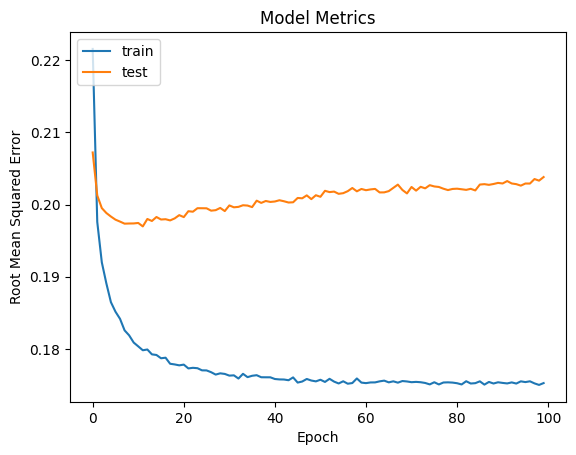

In [51]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 8.4 Mendapatkan Rekomendasi Film

In [52]:
movies = movies_data
 
# Mengambil sample user
user_id = ratings_data.userId.sample(1).iloc[0]
movie_watched_by_user = ratings_data[ratings_data.userId == user_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
movie_not_watched = movies[~movies['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId'] 
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)
 
movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

### 8.5 Hasil Rekomendasi film untuk User

In [53]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]
# Showing Recommendations for Users
print('Showing Recommendations for User: {}'.format(user_id))
print('===' * 9)

# Movie with High Ratings from User
print('Movie with High Ratings from User')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows_user = movies[movies['movieId'].isin(top_movie_user)]
for row in movie_df_rows_user.itertuples():
    print(row.title, ':', row.genres)

print('----' * 8)

# Top 10 Movie Recommendation
print('Top 10 Movie Recommendations')
print('----' * 8)

recommended_movie = movies[movies['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)


314/314 [==============================] - 0s 638us/step
Showing Recommendations for User: 331
Movie with High Ratings from User
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Parent Trap, The (1961) : Children|Comedy|Romance
Pollyanna (1960) : Children|Comedy|Drama
Parent Trap, The (1998) : Children|Comedy|Romance
Harry Potter and the Prisoner of Azkaban (2004) : Adventure|Fantasy|IMAX
--------------------------------
Top 10 Movie Recommendations
--------------------------------
Schizopolis (1996) : Comedy
Fireworks (Hana-bi) (1997) : Crime|Drama
Wings (1927) : Action|Drama|Romance|War
Bandit Queen (1994) : Drama
Antwone Fisher (2002) : Drama
Interstate 60 (2002) : Adventure|Comedy|Drama|Fantasy|Mystery|Sci-Fi|Thriller
Nobody Knows (Dare mo shiranai) (2004) : Drama
Gentlemen of Fortune (Dzhentlmeny udachi) (1972) : Comedy|Crime|Drama|Mystery
Resident Evil: Retribution (2012) : Action|Horror|Sci-Fi|IMAX
Louis C.K.: Live at The Comed